In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch    
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler 
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader

import time
import os
from PIL import Image

In [4]:
np.random.seed(0)
torch.manual_seed(0) 

class CustomSubset(torch.utils.data.Subset):
    def __init__(self, dataset, indices, transform=None, target_transform=None):
        super(CustomSubset, self).__init__(dataset, indices)
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]

        if isinstance(img, torch.Tensor):
            # If the image is already a tensor, don't apply the transform
            transformed_img = img
        else:
            # Apply the transform if the image is a PIL Image or a NumPy array
            transformed_img = self.transform(img) if self.transform is not None else img

        if self.target_transform is not None:
            label = self.target_transform(label)

        return transformed_img, label


def get_weighted_data_loaders(root_dir, batch_size):

    image_transforms = {
        "train": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
        ])
    }

    img_dataset = datasets.ImageFolder(
        root = root_dir,
        transform = image_transforms["train"]
    )  

    idx2class = {v: k for k, v in img_dataset.class_to_idx.items()}

    def get_class_distribution(dataset_obj):
        count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}

        for element in dataset_obj:
            y_lbl = element[1]
            y_lbl = idx2class[y_lbl]
            count_dict[y_lbl] += 1

        return count_dict

    # Split the dataset into train and validation sets
    train_size = int(0.8 * len(img_dataset))
    val_size = len(img_dataset) - train_size
    print(train_size)
    print(val_size)
    train_dataset, val_dataset = random_split(img_dataset, [train_size, val_size])

    target_list = torch.tensor([train_dataset.dataset.targets[i] for i in train_dataset.indices])
    print(len(target_list))
    class_count = [i for i in get_class_distribution(train_dataset.dataset).values()]
    class_weights = 1./torch.tensor(class_count, dtype=torch.float)
    class_weights_all = class_weights[target_list]
    weighted_sampler = WeightedRandomSampler(
        weights=class_weights_all,
        num_samples=len(class_weights_all),
        replacement=True
    )

    # Create data loaders for train and validation datasets
    # train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=batch_size, sampler=train_weighted_sampler)
    train_loader = DataLoader(dataset=CustomSubset(train_dataset.dataset, train_dataset.indices, transform=image_transforms["train"]), shuffle=False, batch_size=1, sampler=weighted_sampler)
    val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)
    
    print("Length of the train_loader:", len(train_loader))
    print("Length of the val_loader:", len(val_loader))

    return train_loader, val_loader, train_size, val_size

In [5]:
train_loader, valid_loader, train_size, valid_size = get_weighted_data_loaders("CNN_images_Run2/CNN_Q102", 8)

537
135
537
Length of the train_loader: 537
Length of the val_loader: 135


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
# applying transforms to the data
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# number of epochs
epochs = 20

# number of classes
num_classes = 2

# load pretrained resnet50, 152 bigger but better perf should try
# Maybe try DenseNet after this :DenseNet161_Weights.IMAGENET1K_V1
resnet_50 = models.resnet50(weights="IMAGENET1K_V2")

# Freeze model parameters, coz we are fine-tuning
for param in resnet_50.parameters():
  param.requires_grad = False

# change the final layer of Resnet50 Model for fine-tuning
fc_inputs = resnet_50.fc.in_features

resnet_50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4), 
    nn.Linear(256, 2), # since we have 2 classes
    nn.LogSoftmax(dim=1) # for using NLLLoss()
)

# convert model to GPU
resnet_50 = resnet_50.to(device)

# define optimizer and loss function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet_50.parameters())

In [8]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels.long())
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_size 
        avg_train_acc = train_acc/train_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_size 
        avg_valid_acc = valid_acc/valid_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        # torch.save(model, 'model_'+str(epoch)+'.pt')
            
    return model, history

Epoch: 1/25
Epoch : 001, Training: Loss: 0.4153, Accuracy: 78.9572%, 
		Validation : Loss : 0.2096, Accuracy: 94.8148%, Time: 7.0756s
Epoch: 2/25
Epoch : 002, Training: Loss: 0.0725, Accuracy: 98.8827%, 
		Validation : Loss : 0.1468, Accuracy: 94.8148%, Time: 6.7272s
Epoch: 3/25
Epoch : 003, Training: Loss: 0.0220, Accuracy: 99.8138%, 
		Validation : Loss : 0.1688, Accuracy: 93.3333%, Time: 6.7117s
Epoch: 4/25
Epoch : 004, Training: Loss: 0.0124, Accuracy: 99.8138%, 
		Validation : Loss : 0.1447, Accuracy: 94.8148%, Time: 6.6619s
Epoch: 5/25
Epoch : 005, Training: Loss: 0.0463, Accuracy: 98.8827%, 
		Validation : Loss : 0.1617, Accuracy: 93.3333%, Time: 6.7306s
Epoch: 6/25
Epoch : 006, Training: Loss: 0.0171, Accuracy: 99.6276%, 
		Validation : Loss : 0.2652, Accuracy: 92.5926%, Time: 6.5660s
Epoch: 7/25
Epoch : 007, Training: Loss: 0.0034, Accuracy: 100.0000%, 
		Validation : Loss : 0.1713, Accuracy: 94.8148%, Time: 6.6504s
Epoch: 8/25
Epoch : 008, Training: Loss: 0.0024, Accuracy: 10

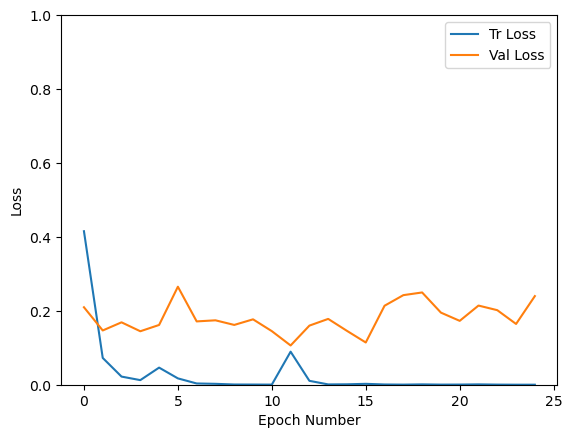

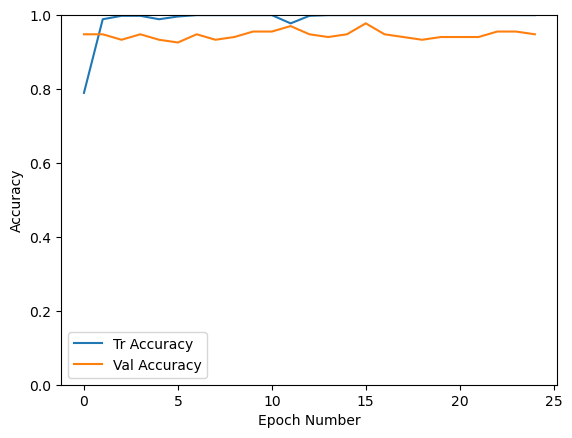

In [9]:
num_epochs = 25
trained_model, history = train_and_validate(resnet_50, loss_func, optimizer, num_epochs)
torch.save(history, 'history_CNN_Q102.pt')

torch.save(trained_model,'trained_model_CNN_Q102.pt')

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig('loss_curve.png')
plt.show()

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('_accuracy_curve.png')
plt.show()